In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.funcs import *
from pathlib import Path
from collections import defaultdict

# stats
from scipy.stats import mannwhitneyu
# survival analysis
from lifelines.statistics import logrank_test

sns.set(font_scale = 1.25,
        style="whitegrid",
        rc={"figure.dpi":300, 'savefig.dpi':300, 'figure.figsize':(8,6)})

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path.home() / "data/bioinfo_sm207"

In [4]:
response = pd.read_parquet(data_path/"step01_zuma7_response.parquet")
response.head()

,Core ID,LV8 Molecular Batch ID,Subject ID_old,Collection Date_old,Site ID_old,Visit_old,Treatment_Arm_01,Randomization_Date,Treatment_Start_Date 01,HDT_Date_01,...,granulator_Neutrophils.LD_group,granulator_NK_group,granulator_pDCs_group,granulator_Plasmablasts_group,granulator_T.CD4.Memory_group,granulator_T.CD4.Naive_group,granulator_T.CD8.Memory_group,granulator_T.CD8.Naive_group,granulator_T.gd.non.Vd2_group,granulator_T.gd.Vd2_group
SM201-001,SM201-001,N1800110-KTP-00001,107-002-001,2017-08-08 00:00:00,2,Screening,Axicabtagene Ciloleucel,2018-01-25 00:00:00,2018-02-19 00:00:00,.,...,high,low,low,low,low,high,high,low,low,low
SM201-003,SM201-003,N1800110-KTP-00003,107-002-002,2017-04-13 00:00:00,2,Screening,Axicabtagene Ciloleucel,2018-01-31 00:00:00,2018-02-26 00:00:00,.,...,low,low,low,low,low,high,low,low,low,low
SM201-004,SM201-004,N1800110-KTP-00004,107-005-001,2017-08-14 00:00:00,5,Screening,Standard of Care Therapy,2018-02-09 00:00:00,2018-02-15 00:00:00,.,...,low,low,low,low,high,high,low,high,low,low
SM201-005,SM201-005,N1800110-KTP-00005,107-031-001,2018-04-03 00:00:00,31,Screening,Standard of Care Therapy,2018-03-30 00:00:00,2018-04-04 00:00:00,2018-06-13 00:00:00,...,high,low,low,low,high,low,high,low,low,low
SM201-006,SM201-006,N1800110-KTP-00006,107-019-002,2018-03-30 00:00:00,19,Screening,Standard of Care Therapy,2018-03-30 00:00:00,2018-03-31 00:00:00,.,...,low,low,low,low,low,high,low,low,low,low


In [5]:
celltypes = [c for c in response.columns if c.startswith("granulator") and "group" not in c]
len(celltypes)

17

In [6]:
response["Ongoing Response"].value_counts()

Other               146
Ongoing Response     73
Missing              30
Name: Ongoing Response, dtype: int64

In [7]:
pvals = {}
ratios = {}

# calcluate median ratios and p values between Ongoing Response and other
for cell in celltypes:        
    tmp = response.loc[response["Actual Arm Code"] == "AXICEL"].copy()
    ongoing = tmp.loc[tmp["Ongoing Response"]=="Ongoing Response", cell].values
    other = tmp.loc[tmp["Ongoing Response"]=="Other", cell].values
    # Mann-Whitney U test
    _, p = mannwhitneyu(ongoing, other)
    pvals[cell] = p
    # ratio
    ratios[cell] = np.median(ongoing) / np.median(other)

In [8]:
# plotting
zuma7_res1 = pd.concat([pd.Series(pvals, name="P value (Mann-Whitney U)"),
                       pd.Series(ratios, name="Median Ratio (Ongoing vs. Other)")], axis=1)
zuma7_res1.head()

,P value (Mann-Whitney U),Median Ratio (Ongoing vs. Other)
granulator_B.Memory,0.006921,1.500967
granulator_B.Naive,0.070245,2.005814
granulator_Basophils.LD,0.375663,NaN
granulator_MAIT,0.061978,1.000000
granulator_mDCs,0.922727,NaN


<Axes: xlabel='Median Ratio (Ongoing vs. Other)', ylabel='P value (Mann-Whitney U)'>

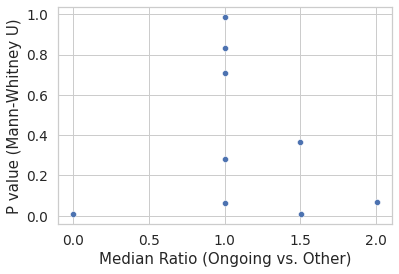

In [9]:
sns.scatterplot(data=zuma7_res1, x="Median Ratio (Ongoing vs. Other)",
                y="P value (Mann-Whitney U)")

In [10]:
generate_stats(response, "AXICEL", ["PFS"], "granulator_B.Memory_group")

,Arm,group_col,param,P value,HR,lower,higher
0,AXICEL,granulator_B.Memory_group,PFS,0.014179,0.534091,0.320912,0.888884


In [11]:
from lifelines import CoxPHFitter
tmp = response.loc[response["Actual Arm Code"] == "AXICEL"].copy()
tmp.dropna(subset=[f"PFS time", f"PFS event"], inplace=True)
cph = CoxPHFitter()
cph.fit(
    tmp,
    duration_col=f"PFS time",
    event_col=f"PFS event",
    formula="granulator_B.Memory_group",
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 124 total observations, 59 right-censored observations>
             duration col = 'PFS time'
                event col = 'PFS event'
      baseline estimation = breslow
   number of observations = 124
number of events observed = 65
   partial log-likelihood = -281.16
         time fit was run = 2023-10-20 20:21:14 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                 
granulator_B.Memory_group[T.high]  -0.63       0.53       0.26            -1.14            -0.12                 0.32                 0.89

                                    cmp to     z    p   -log2(p)
covariate                                                       
granulator_B.Memory_group[T.high]     0.00 -2.41 0.02       5.98
---
Concordance = 0.58
Partial AIC = 564.32
log-likelihood ratio test = 6.04 on 1 df
-log2(p) of ll-ratio test = 6.16

In [12]:
# HR for PFS
logrank_pvalues = {}
hrs= {}
for cell in celltypes:
    try:
        df = generate_stats(response, "AXICEL", ["PFS"], f"{cell}_group")
        logrank_pvalues[cell] = df["P value"].values[0]
        hrs[cell] = df["HR"].values[0]
    except:
        logrank_pvalues[cell] = np.nan
        hrs[cell] = np.nan

In [13]:
zuma7_res2 = pd.concat([pd.Series(logrank_pvalues, name="P value (Log rank)"),
                        pd.Series(hrs, name="Hazard Ratio")], axis=1)
zuma7_res2.head()

,P value (Log rank),Hazard Ratio
granulator_B.Memory,0.014179,0.534091
granulator_B.Naive,0.033033,0.551398
granulator_Basophils.LD,0.515862,1.347967
granulator_MAIT,0.140666,1.796390
granulator_mDCs,0.908095,1.034269


In [14]:
zuma_res = pd.merge(zuma7_res1, zuma7_res2,
                    left_index=True, right_index=True,
                    how="outer")
zuma_res.shape

(17, 4)

In [15]:
zuma_res

,P value (Mann-Whitney U),Median Ratio (Ongoing vs. Other),P value (Log rank),Hazard Ratio
granulator_B.Memory,0.006921,1.500967,0.014179,5.340913e-01
granulator_B.Naive,0.070245,2.005814,0.033033,5.513983e-01
granulator_Basophils.LD,0.375663,NaN,0.515862,1.347967e+00
granulator_MAIT,0.061978,1.000000,0.140666,1.796390e+00
granulator_mDCs,0.922727,NaN,0.908095,1.034269e+00
granulator_Monocytes.C,0.411385,NaN,0.541689,1.168749e+00
granulator_Monocytes.NC.I,0.283967,1.000000,0.247964,1.414930e+00
granulator_Neutrophils.LD,0.367196,1.498551,0.478701,8.382628e-01
granulator_NK,1.000000,NaN,NaN,NaN
granulator_pDCs,0.709446,1.000000,0.218792,1.692628e+00


In [16]:
response.loc[response["Actual Arm Code"]=="AXICEL"]["granulator_NK_group"].value_counts()

low     124
high      0
Name: granulator_NK_group, dtype: int64

In [17]:
response.loc[response["Actual Arm Code"]=="AXICEL"]["granulator_T.CD4.Naive"].describe()

count    124.000000
mean       1.097500
std        1.605389
min        0.000000
25%        0.000000
50%        0.000000
75%        1.720000
max        6.900000
Name: granulator_T.CD4.Naive, dtype: float64

In [18]:
response.loc[response["Actual Arm Code"]=="AXICEL"]["granulator_Plasmablasts"].describe()

count    124.000000
mean       0.027742
std        0.217550
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.720000
Name: granulator_Plasmablasts, dtype: float64

In [19]:
response.loc[response["Actual Arm Code"]=="AXICEL"]["granulator_Plasmablasts_group"].value_counts()

low     122
high      2
Name: granulator_Plasmablasts_group, dtype: int64

In [20]:
zuma_res.index = zuma_res.index.map(lambda x: x.replace("granulator_", ""))
zuma_res.head()

,P value (Mann-Whitney U),Median Ratio (Ongoing vs. Other),P value (Log rank),Hazard Ratio
B.Memory,0.006921,1.500967,0.014179,0.534091
B.Naive,0.070245,2.005814,0.033033,0.551398
Basophils.LD,0.375663,NaN,0.515862,1.347967
MAIT,0.061978,1.000000,0.140666,1.796390
mDCs,0.922727,NaN,0.908095,1.034269


In [21]:
zuma_res.to_csv(data_path/"step05_zuma7_results.csv")